In [2]:
#pip install nilearn nibabel seaborn networkx nxviz community sklearn matplotlib plotly dash


In [3]:
# Libraries
from nilearn import datasets
import pandas as pd
from nilearn import plotting
import nibabel as nib
import matplotlib.pyplot as plt
from nilearn.image import resample_to_img
from sklearn.metrics import jaccard_score
import nilearn
from nilearn import datasets
from nilearn.input_data import NiftiLabelsMasker
from nilearn.connectome import ConnectivityMeasure
import numpy as np
import glob
#import seaborn as sns
# Network Libraries
import networkx as nx
#from nxviz import CircosPlot
import community
import plotly 
#import dash
import os
from PIL import Image
import tqdm


In [4]:
atlas = datasets.fetch_atlas_schaefer_2018(n_rois=100, yeo_networks=7)
atlas.labels=atlas.labels.tolist()
atlas_labels = [label.decode('utf-8') for label in atlas.labels]
atlas_filename=atlas.maps

In [5]:
# def load_data(subject,iter,ses):

#         # Locate the data of the first subject
#         func = f'/home/mina94/scratch/fixSeed_threads/fmriprep_mca-output/iter_{iter}/{subject}/ses-{ses}/func/{subject}_ses-{ses}_task-rest_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz'
#         #template used 
#         template='/home/mina94/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz'
#         # atlas = datasets.fetch_atlas_schaefer_2018(n_rois=100, yeo_networks=7)
#         #atlas='/home/mina94/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_atlas-Schaefer2018_desc-100Parcels17Networks_dseg.nii.gz'
#        #maybe add this atlas feature in public env t obe accessible
#         # atlas.labels=atlas.labels.tolist()
#         # atlas_labels = [label.decode('utf-8') for label in atlas.labels]
#         return func, template

In [6]:
def compute_timeseries(sub,iter, ses): #(func,sub,iter, ses)
    func = f'/home/mina94/scratch/fixSeed_threads/fmriprep_mca-output/iter_{iter}/{sub}/ses-{ses}/func/{sub}_ses-{ses}_task-rest_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz'
    # func = f'/home/mina94/scratch/fixSeed_threads/fmriprep_ieee-output/iter_{iter}/{sub}/ses-{ses}/func/{sub}_ses-{ses}_task-rest_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz'
    fmri_img=nib.load(func)
    confounds_fn = f'/home/mina94/scratch/fixSeed_threads/fmriprep_mca-output/iter_{iter}/{sub}/ses-{ses}/func/{sub}_ses-{ses}_task-rest_desc-confounds_timeseries.tsv'
    # confounds_fn = f'/home/mina94/scratch/fixSeed_threads/fmriprep_ieee-output/iter_{iter}/{sub}/ses-{ses}/func/{sub}_ses-{ses}_task-rest_desc-confounds_timeseries.tsv'
    # We need to load the confounds and fill nas
    confounds = pd.read_table(confounds_fn).fillna(method='bfill')
    confounds_to_include = ['global_signal', 'csf',
                                'white_matter', 'trans_x', 'trans_y',
                                'trans_z', 'rot_x', 'rot_y', 'rot_z', 'trans_x_power2',
                                'trans_y_power2', 'trans_z_power2', 'rot_x_power2', 'rot_y_power2', 'rot_z_power2']
    confounds = confounds[confounds_to_include]
    # Initialize the NiftiLabelsMasker with some standard options for preprocessing
    masker = NiftiLabelsMasker(atlas_filename, standardize=True, smoothing_fwhm=6,memory='nilearn_cache', verbose=5)
    time_series = masker.fit_transform(fmri_img, confounds)
    #plot the correlation matrix
    correlation_measure = ConnectivityMeasure(kind='correlation')
    correlation_matrix = correlation_measure.fit_transform([time_series])[0]
    # correlation_matrix[correlation_matrix<=0.005] = 0 applying threshold

    # Mask the main diagonal for visualization:
    np.fill_diagonal(correlation_matrix, 0)
    # Plot correlation matrix - note: matrix is ordered for block-like representation
    # title = f'iter_{iter}'
    # fig= plotting.plot_matrix(correlation_matrix, title=title, figure=(8,8), labels=atlas_labels,
    #                  vmax=0.8, vmin=-0.8, reorder=False);
    # Save the plot, create ses folder for each subject
    # fig.figure.savefig((f'{save_filepath}/views/{sub}/{ses}/{iter}_views.png'))
    # print(f'save the plot of {sub} for {iter} in {save_filepath}/views/{sub}/{ses}/{iter}_views.png')
    # plt.close(fig.figure)

    return time_series, correlation_matrix


In [7]:
def building_graph (correlation_matrix):
    G = nx.Graph()
    # Add nodes to the graph
    num_nodes = correlation_matrix.shape[0]
    G.add_nodes_from(range(num_nodes))
    print(f"Graph G with {num_nodes} nodes was built")
    # Add edges based on correlation matrix
    threshold = 0.05  # Adjust this threshold as needed
    #G.add_edges([(i, j, correlation_matrix[i, j] for i in ... for j in ...)])
    for i in range(num_nodes):
        for j in range(i + 1, num_nodes):
            #if j == i:
                #continue
            correlation = correlation_matrix[i, j]
            if abs(correlation) >= threshold:
                G.add_edge(i, j, weight=correlation)
    # Removing self-loops
    G.remove_edges_from(list(nx.selfloop_edges(G)))
    return G

In [8]:
def compute_graph_measures(G):
    # Compute centrality
    degree_centralities = nx.degree_centrality(G)
    betweenness_centralities = nx.betweenness_centrality(G)
    eigenvector_centralities = nx.eigenvector_centrality(G)

    # Compute clustering coefficient
    clustering_coefficients = nx.clustering(G)

    # Compute shortest path lengths
    shortest_path_lengths = dict(nx.shortest_path_length(G))

    # Compute clustering coefficient
    avg_clustering_coefficient = nx.average_clustering(G)

    # Compute average shortest path length
    avg_shortest_path_length = nx.average_shortest_path_length(G)

    # Compute small-worldness
    small_worldness = avg_clustering_coefficient / avg_shortest_path_length
        # Construct the dictionary of graph metrics
    graph_metrics = {
        'degree_centralities': degree_centralities,
        'betweenness_centralities': betweenness_centralities,
        'eigenvector_centralities': eigenvector_centralities,
        'clustering_coefficients': clustering_coefficients,
        'shortest_path_lengths': shortest_path_lengths,
        'small_worldness': small_worldness
    }

    return graph_metrics
    
    # return {
    #     'degree_centralities': nx.degree_centrality(G),
    #     ...
    # }


In [9]:
# # base = 'fmriprep_mca-output'
# save_filepath='connectome_gifs'
# for sub in range (1,11): 
#         if sub < 10:
#             sub = f'sub-126BPCP02100{sub}'
#         else:
#             sub = 'sub-126BPCP021010'
#         for iter in tqdm.tqdm(range(1,11)):
#             try:
#                 func, template, confounds, atlas=load_data(sub,iter)
#                 # Plot MRI image without coordinate axes
#                 iter_dict[f'iter_{iter}'][f'{sub}']['time_series'], iter_dict[f'iter_{iter}'][f'{sub}']['correlation_matrix'] =   compute_timeseries(atlas , func,sub,iter,save_filepath)
#             except Exception as e:
#                 print(e)
#                 continue
#         frames = [Image.open(f'{save_filepath}/views/{sub}/{image}') for image in os.listdir(f'{save_filepath}/views/{sub}')]
#         frame_one = frames[0]

#         frame_one.save(f"{save_filepath}/{sub}.gif", format="GIF", append_images=frames,save_all=True, duration=200, loop=0)
#         print('Gif of one subject is made')


In [10]:
iter_dict={'iter_1':{}, 'iter_2': {}, 'iter_3': {},'iter_4': {},'iter_5': {},'iter_6': {},'iter_7': {},'iter_8': {},'iter_9': {},'iter_10': {}}
#iter_dict = { f'iter_{i}': {} for i in range(1, 11)}

In [11]:
#creating dictionary for each subject that include number of MCA runs dictonary of features, maybe for each session or run mak differen dictionary
"""
{'sub-126BPCP021007': {'iter_1': {},'iter_2': {},'iter_3': {},'iter_4': {}, 'iter_5': {}, 'iter_6': {}, 'iter_7': {}, 'iter_8': {},  'iter_9': {},  'iter_10': {}},
 'sub-126BPCP021009': {'iter_1': {}, 'iter_2': {}, 'iter_3': {}, 'iter_4': {}, 'iter_5': {}, 'iter_6': {}, 'iter_7': {}, 'iter_8': {}, 'iter_9': {}, 'iter_10': {}},
 'sub-126BPCP021003': {'iter_1': {}, 'iter_2': {}, 'iter_3': {}, 'iter_4': {}, ....
 }
"""
def create_subdict(base):
     sublist=[]
     for subj in glob.glob(f'{base}/iter_1/sub-*'):
          if subj.endswith('.html'):
            continue  # Skip elements that end with .HTML
          sub_id = os.path.basename(subj)
          sublist.append(sub_id)
     #Initialize the outer dictionary for each subject
     iter_names = ['iter_1', 'iter_2', 'iter_3', 'iter_4', 'iter_5', 'iter_6', 'iter_7', 'iter_8', 'iter_9', 'iter_10']

     # Initialize the main dictionary
     iter_dict = {subject: {iter_name: {} for iter_name in iter_names} for subject in sublist}      

     return iter_dict    


In [12]:
subdict_ses1=create_subdict('/home/mina94/scratch/fixSeed_threads/fmriprep_mca-output')

In [13]:

def compute_metrics_forall(subdict,ses):
    for sub, iter in subdict.items():
        for iters in iter.items():
            iters=iters[0]
            i=int(iters.split('_')[1])
            # func, template, confounds=load_data(sub,i, ses)
            subdict[sub][iters]['time_series'], subdict[sub][iters]['correlation_matrix'] =   compute_timeseries(sub, i, ses)
            subdict[sub][iters]['graph']= building_graph(subdict[sub][iters]['correlation_matrix'])
            subdict[sub][iters]['graph_metrics']= compute_graph_measures(subdict[sub][iters]['graph'])
                                                              
compute_metrics_forall(subdict_ses1,1)

/tmp/ipykernel_1524691/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.6s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1524691/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.3s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.1s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1524691/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.3s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1524691/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.3s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1524691/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.4s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.1s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1524691/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.2s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.1s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1524691/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]3.3s, 0.1min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1524691/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.4s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1524691/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.5s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.1s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1524691/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]2.0s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.1s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1524691/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.5s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.1s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1524691/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.4s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1524691/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.4s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1524691/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.5s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1524691/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.4s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1524691/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.3s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1524691/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.4s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1524691/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.5s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1524691/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.8s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1524691/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]2.0s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.8s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1524691/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.4s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1524691/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.6s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.1s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1524691/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.7s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.1s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1524691/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.9s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.1s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1524691/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.5s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1524691/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.4s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1524691/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.4s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1524691/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.4s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1524691/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.5s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.1s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1524691/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.4s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.2s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1524691/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.4s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1524691/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.4s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.1s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1524691/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.2s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1524691/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.2s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1524691/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.3s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1524691/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.2s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.1s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1524691/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.3s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1524691/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.2s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.1s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1524691/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.4s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1524691/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.2s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1524691/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.4s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1524691/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.3s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1524691/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.2s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1524691/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.3s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1524691/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.2s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1524691/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.2s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1524691/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.3s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1524691/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.3s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1524691/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.3s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.1s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1524691/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.4s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1524691/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.3s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1524691/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.2s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1524691/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.3s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1524691/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.3s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.1s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1524691/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.4s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.1s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1524691/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]4.3s, 0.1min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.1s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1524691/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.9s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.1s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1524691/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.6s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1524691/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.3s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1524691/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.3s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.1s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1524691/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.4s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1524691/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.3s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1524691/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.5s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1524691/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.2s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1524691/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.3s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1524691/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.2s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.1s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1524691/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.3s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1524691/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.8s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1524691/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.9s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1524691/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.7s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1524691/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.9s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.1s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1524691/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.8s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1524691/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]2.0s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1524691/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.9s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.1s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1524691/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]2.1s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1524691/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]2.0s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1524691/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.9s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1524691/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]2.5s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.1s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1524691/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]2.2s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.1s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1524691/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.8s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1524691/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.7s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1524691/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]2.1s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1524691/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.8s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.1s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1524691/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]2.1s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.1s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1524691/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]2.2s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1524691/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]2.9s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1524691/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]2.0s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.2s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1524691/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.9s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1524691/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]2.0s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1524691/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.5s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1524691/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.8s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1524691/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.4s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1524691/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.6s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1524691/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.6s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.1s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1524691/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.3s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1524691/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.4s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.1s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1524691/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.3s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1524691/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.3s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1524691/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.2s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1524691/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.4s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.1s, 0.0min
Graph G with 100 nodes was built


In [14]:
subdict_ses1['sub-126BPCP021010']['iter_6']['graph_metrics']['eigenvector_centralities']

{0: 0.08709950146611495,
 1: 0.10485792348814932,
 2: 0.09891505716354454,
 3: 0.10039093339817172,
 4: 0.0938424875767103,
 5: 0.09858371860005417,
 6: 0.10667759225698487,
 7: 0.1042836546123957,
 8: 0.10694170276344483,
 9: 0.10005788358841369,
 10: 0.09584898412543619,
 11: 0.0991349677862472,
 12: 0.09678522954857904,
 13: 0.0982354679047375,
 14: 0.09616395228287218,
 15: 0.10206715943711217,
 16: 0.09639138249479923,
 17: 0.10099869446083207,
 18: 0.09746519479280778,
 19: 0.09832545587488649,
 20: 0.10541052313434535,
 21: 0.09993169394816677,
 22: 0.10324438199143351,
 23: 0.10683128543745625,
 24: 0.10005695183041749,
 25: 0.09926516487795904,
 26: 0.10220689295677908,
 27: 0.09512452989557577,
 28: 0.09648926842377578,
 29: 0.09836894632557198,
 30: 0.09411385217391713,
 31: 0.0849439803616474,
 32: 0.1005105246770555,
 33: 0.09978724855074422,
 34: 0.09531677264834446,
 35: 0.1068435167256227,
 36: 0.09355041997923293,
 37: 0.10773704274237537,
 38: 0.09184291979716634,
 39

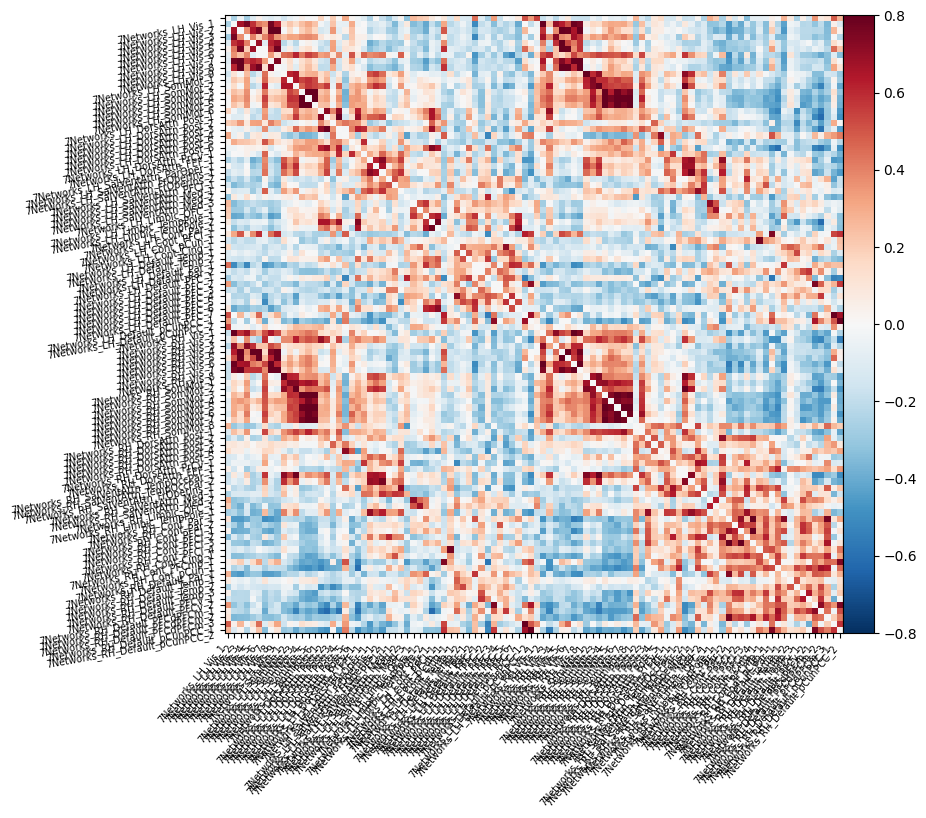

In [15]:
#figure the correlation matrix
correlation_matrix=subdict_ses1['sub-126BPCP021010']['iter_6']['correlation_matrix']
# correlation_matrix_copy =  correlation_matrix.copy()
# correlation_matrix_copy[correlation_matrix_copy<0.005]=0 
plotting.plot_matrix(correlation_matrix,figure=(8,8),labels=atlas_labels,
                     vmax=0.8, vmin=-0.8, reorder=False);


In [16]:

for sub, iter in subdict_ses1.items():
    subdict_ses1[sub]['std_metric'] = {
        'std_degree': [],
        'std_betweeness': [],
        'std_eigen': [],
        'std_clusteringCoefficient': []
                                          }
    for item , val in iter.items(): 
        if "iter" in item:
            std_degree=  np.std(list(subdict_ses1[sub][item]['graph_metrics']['degree_centralities'].values()))
            std_betweeness=np.std(list(subdict_ses1[sub][item]['graph_metrics']['betweenness_centralities'].values())) 
            std_eigen =np.std(list(subdict_ses1[sub][item]['graph_metrics']['eigenvector_centralities'].values())) 
            std_clusteringCoefficient = np.std(list(subdict_ses1[sub][item]['graph_metrics']['clustering_coefficients'].values()))
            # print(f'The std value of metric for subject {sub} and iteration {item} : std_degree: {std_degree}, std_betweeness: {std_betweeness}, std_eigen :{std_eigen}, std_clustering_coefficient:{std_clusteringCoefficient}')    
            subdict_ses1[sub]['std_metric']['std_degree'].append(std_degree)
            subdict_ses1[sub]['std_metric']['std_betweeness'].append(std_betweeness)
            subdict_ses1[sub]['std_metric']['std_eigen'].append(std_eigen)
            subdict_ses1[sub]['std_metric']['std_clusteringCoefficient'].append(std_clusteringCoefficient)

In [17]:
print(subdict_ses1['sub-126BPCP021001']['std_metric']['std_degree'])

[0.05974506258098519, 0.06037836013688266, 0.0588607275388559, 0.05828904261112528, 0.05956205164467427, 0.05954937401961457, 0.06002244249190134, 0.05715279695496568, 0.0590109966423375, 0.05846382274136478]


In [18]:
# df=pd.DataFrame.from_dict(subdict_ses1['sub-126BPCP021001']['std_metric'])
# long_df = pd.melt(df)
# long_df

In [19]:
# pip install seaborn

In [20]:
IEEE_metric = { f'sub-126BPCP021{i:03}': {} for i in range(1, 11)}

for i in range (1,11):
    sub= f'sub-126BPCP021{i:03}'
    print (sub)
    IEEE_metric[sub] = {}
    IEEE_metric[sub]['time_series'], IEEE_metric[sub]['correlation_matrix'] =   compute_timeseries(sub, 1,1)
    IEEE_metric[sub]['graph']= building_graph(IEEE_metric[sub]['correlation_matrix'])
    IEEE_metric[sub]['graph_metrics']= compute_graph_measures(IEEE_metric[sub]['graph'])

sub-126BPCP021001


/tmp/ipykernel_1524691/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.1s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Graph G with 100 nodes was built
sub-126BPCP021002


/tmp/ipykernel_1524691/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.2s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Graph G with 100 nodes was built
sub-126BPCP021003


/tmp/ipykernel_1524691/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.5s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.1s, 0.0min
Graph G with 100 nodes was built
sub-126BPCP021004


/tmp/ipykernel_1524691/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.3s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Graph G with 100 nodes was built
sub-126BPCP021005


/tmp/ipykernel_1524691/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.2s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Graph G with 100 nodes was built
sub-126BPCP021006


/tmp/ipykernel_1524691/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.6s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Graph G with 100 nodes was built
sub-126BPCP021007


/tmp/ipykernel_1524691/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.4s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Graph G with 100 nodes was built
sub-126BPCP021008


/tmp/ipykernel_1524691/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.2s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Graph G with 100 nodes was built
sub-126BPCP021009


/tmp/ipykernel_1524691/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.2s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Graph G with 100 nodes was built
sub-126BPCP021010


/tmp/ipykernel_1524691/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.3s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Graph G with 100 nodes was built


In [21]:
# for sub, iter in IEEE_metric.items():
#         IEEE_metric[sub]['std_metric'] = {
#         'std_degree': [],
#         'std_betweeness': [],
#         'std_eigen': [],
#         'std_clusteringCoefficient': []}
#         IEEE_metric[sub]['std_metric']['std_degree']=  np.std(list(IEEE_metric[sub]['graph_metrics']['degree_centralities'].values()))
#         IEEE_metric[sub]['std_metric']['std_betweeness']=np.std(list(IEEE_metric[sub]['graph_metrics']['betweenness_centralities'].values())) 
#         IEEE_metric[sub]['std_metric']['std_eigen'] =np.std(list(IEEE_metric[sub]['graph_metrics']['eigenvector_centralities'].values())) 
#         IEEE_metric[sub]['std_metric']['std_clusteringCoefficient'] = np.std(list(IEEE_metric[sub]['graph_metrics']['clustering_coefficients'].values()))
#         print(f'The std value of metric for subject {sub}: std_degree: {std_degree}, std_betweeness: {std_betweeness}, std_eigen :{std_eigen}, std_clustering_coefficient:{std_clusteringCoefficient}')    
        

In [22]:

# Loop over subjects and iterations
for sub, metrics in IEEE_metric.items():
    # Initialize the std_metric dictionary
    std_metrics = {
        'std_degree': np.std(list(metrics['graph_metrics']['degree_centralities'].values())),
        'std_betweeness': np.std(list(metrics['graph_metrics']['betweenness_centralities'].values())),
        'std_eigen': np.std(list(metrics['graph_metrics']['eigenvector_centralities'].values())),
        'std_clusteringCoefficient': np.std(list(metrics['graph_metrics']['clustering_coefficients'].values()))
    }

    # Update the IEEE_metric dictionary with computed std_metrics
    IEEE_metric[sub]['std_metric'] = std_metrics

    # Print the results for each subject
    print(f"The std value of metric for subject {sub}: "
          f"std_degree: {std_metrics['std_degree']}, "
          f"std_betweeness: {std_metrics['std_betweeness']}, "
          f"std_eigen: {std_metrics['std_eigen']}, "
          f"std_clustering_coefficient: {std_metrics['std_clusteringCoefficient']}")

The std value of metric for subject sub-126BPCP021001: std_degree: 0.05974506258098519, std_betweeness: 0.00018481300270800679, std_eigen: 0.0067225260205426044, std_clustering_coefficient: 0.007014913022696978
The std value of metric for subject sub-126BPCP021002: std_degree: 0.06614704134321793, std_betweeness: 0.0002780004078876756, std_eigen: 0.00760799501503572, std_clustering_coefficient: 0.008640515418257739
The std value of metric for subject sub-126BPCP021003: std_degree: 0.052736173249324385, std_betweeness: 0.0002010800006472423, std_eigen: 0.0061642615601705635, std_clustering_coefficient: 0.005646410574149304
The std value of metric for subject sub-126BPCP021004: std_degree: 0.05945883900105632, std_betweeness: 0.00020023148357040037, std_eigen: 0.006774496153015136, std_clustering_coefficient: 0.007071824984271665
The std value of metric for subject sub-126BPCP021005: std_degree: 0.06355325661911604, std_betweeness: 0.00023192712463245113, std_eigen: 0.007498313739654725,

In [23]:
subdict_ses1['sub-126BPCP021001']['']

KeyError: ''

In [24]:
# Initialize empty cumulative metric values
cumulative_metric_values = {
    'betweenness_centralities': [],
    'clustering_coefficients': [],
    'degree_centralities': [],
    'eigenvector_centralities': []
}

# Iterate over subjects and items
for sub, iter in subdict_ses1.items():
    for item, val in iter.items():
        if "iter" in item:
            print(sub,item)
            betweenness_centralities = list(subdict_ses1[sub][item]['graph_metrics']['betweenness_centralities'].values())
            clustering_coefficients = list(subdict_ses1[sub][item]['graph_metrics']['clustering_coefficients'].values())
            degree_centralities = list(subdict_ses1[sub][item]['graph_metrics']['degree_centralities'].values())
            eigenvector_centralities = list(subdict_ses1[sub][item]['graph_metrics']['eigenvector_centralities'].values())

            # Accumulate values for each metric
            cumulative_metric_values['betweenness_centralities'].extend(
                betweenness_centralities
            )
            cumulative_metric_values['clustering_coefficients'].extend(
                clustering_coefficients
            )
            cumulative_metric_values['degree_centralities'].extend(
                degree_centralities
            )
            cumulative_metric_values['eigenvector_centralities'].extend(
                eigenvector_centralities
            )



df = pd.DataFrame(cumulative_metric_values)

# Print the DataFrame
print(df)

# Save the DataFrame to a CSV file
df.to_csv('/home/mina94/scratch/fixSeed_threads/cumulative_metrics_MCA.csv', index=False)



sub-126BPCP021007 iter_1
sub-126BPCP021007 iter_2
sub-126BPCP021007 iter_3
sub-126BPCP021007 iter_4
sub-126BPCP021007 iter_5
sub-126BPCP021007 iter_6
sub-126BPCP021007 iter_7
sub-126BPCP021007 iter_8
sub-126BPCP021007 iter_9
sub-126BPCP021007 iter_10
sub-126BPCP021009 iter_1
sub-126BPCP021009 iter_2
sub-126BPCP021009 iter_3
sub-126BPCP021009 iter_4
sub-126BPCP021009 iter_5
sub-126BPCP021009 iter_6
sub-126BPCP021009 iter_7
sub-126BPCP021009 iter_8
sub-126BPCP021009 iter_9
sub-126BPCP021009 iter_10
sub-126BPCP021003 iter_1
sub-126BPCP021003 iter_2
sub-126BPCP021003 iter_3
sub-126BPCP021003 iter_4
sub-126BPCP021003 iter_5
sub-126BPCP021003 iter_6
sub-126BPCP021003 iter_7
sub-126BPCP021003 iter_8
sub-126BPCP021003 iter_9
sub-126BPCP021003 iter_10
sub-126BPCP021010 iter_1
sub-126BPCP021010 iter_2
sub-126BPCP021010 iter_3
sub-126BPCP021010 iter_4
sub-126BPCP021010 iter_5
sub-126BPCP021010 iter_6
sub-126BPCP021010 iter_7
sub-126BPCP021010 iter_8
sub-126BPCP021010 iter_9
sub-126BPCP021010 iter

In [25]:
list(subdict_ses1['sub-126BPCP021007']['iter_1']['graph_metrics']['betweenness_centralities'].values())

[0.0009915123135232288,
 0.0011558898963222473,
 0.0011187381740097653,
 0.000849984049925718,
 0.0014153961351071355,
 0.0014966568169820411,
 0.001196028521515104,
 0.0013355869088382626,
 0.0012079117870280175,
 0.0009819852774778839,
 0.0011719857432213804,
 0.0012722516469237434,
 0.0012681329845370764,
 0.0014181977701533152,
 0.0010651255187360932,
 0.001662590840639755,
 0.001088047063822588,
 0.0016429731950857258,
 0.0012442777219831636,
 0.0014522320496283864,
 0.0015072414021416647,
 0.0013934646534320358,
 0.0016275486589557885,
 0.0012072248718257158,
 0.000989709004527449,
 0.001278837401137347,
 0.0015569399269384366,
 0.0012948409185354478,
 0.001438696343963083,
 0.0013998048376062063,
 0.0010645653717463567,
 0.0011907354256344624,
 0.0017145911589243365,
 0.0014376992457365058,
 0.0016048547856382161,
 0.0017930464459114102,
 0.0014225529493194131,
 0.0014378408699852667,
 0.001313756175402767,
 0.001374491027815812,
 0.0015525078887912412,
 0.0016305674555870012,
 

In [26]:
# Initialize empty cumulative metric values
cumulative_metric_values_IEEE = {
    'betweenness_centralities': [],
    'clustering_coefficients': [],
    'degree_centralities': [],
    'eigenvector_centralities': []
}
for sub, metric in IEEE_metric.items(): 
                        # Accumulate values for each metric
            cumulative_metric_values_IEEE['betweenness_centralities'].extend(
                list(metric['graph_metrics']['betweenness_centralities'].values())
            )
            cumulative_metric_values_IEEE['clustering_coefficients'].extend(
                list(metric['graph_metrics']['clustering_coefficients'].values())
            )
            cumulative_metric_values_IEEE['degree_centralities'].extend(
                list(metric['graph_metrics']['degree_centralities'].values())
            )
            cumulative_metric_values_IEEE['eigenvector_centralities'].extend(
                list(metric['graph_metrics']['eigenvector_centralities'].values())
            )

df_IEEE = pd.DataFrame(cumulative_metric_values_IEEE)

# Print the DataFrame
print(df_IEEE)

# Save the DataFrame to a CSV file
df.to_csv('/home/mina94/scratch/fixSeed_threads/cumulative_metrics_IEEE.csv', index=False)

     betweenness_centralities  clustering_coefficients  degree_centralities  \
0                    0.001088                 0.889845             0.848485   
1                    0.001264                 0.880164             0.868687   
2                    0.001175                 0.877447             0.828283   
3                    0.001017                 0.884453             0.797980   
4                    0.001139                 0.872444             0.797980   
..                        ...                      ...                  ...   
995                  0.001563                 0.872604             0.939394   
996                  0.001214                 0.882900             0.868687   
997                  0.001471                 0.873504             0.919192   
998                  0.001268                 0.872633             0.848485   
999                  0.001521                 0.866190             0.898990   

     eigenvector_centralities  
0                  

In [ ]:

df = pd.DataFrame(cumulative_metric_values)

# Print the DataFrame
print(df)

# Save the DataFrame to a CSV file
df.to_csv('/home/mina94/scratch/fixSeed_threads/cumulative_metrics.csv', index=False)

      betweenness_centralities  clustering_coefficients  degree_centralities  \
0                            0                        0                    0   
1                            1                        1                    1   
2                            2                        2                    2   
3                            3                        3                    3   
4                            4                        4                    4   
...                        ...                      ...                  ...   
9995                        95                       95                   95   
9996                        96                       96                   96   
9997                        97                       97                   97   
9998                        98                       98                   98   
9999                        99                       99                   99   

      eigenvector_centralities  
0     

In [27]:
statics=pd.DataFrame()
statics['subject']=list(subdict_ses1.keys())
# Loop through each subject and assign values
for i in range(len(statics['subject'])):
    sub = statics['subject'][i]  # Update sub for each iteration
    statics.loc[i, 'max_diff_degree'] = abs(max(subdict_ses1[sub]['std_metric']['std_degree'])-min(subdict_ses1[sub]['std_metric']['std_degree']))
    statics.loc[i, 'max_diff_betweeness'] = abs(max(subdict_ses1[sub]['std_metric']['std_betweeness'])-min(subdict_ses1[sub]['std_metric']['std_betweeness']))
    statics.loc[i, 'max_diff_eigen'] = abs(max(subdict_ses1[sub]['std_metric']['std_eigen'])-min(subdict_ses1[sub]['std_metric']['std_eigen']))
    statics.loc[i, 'max_diff_clusteringcoefficient'] =abs(max( subdict_ses1[sub]['std_metric']['std_clusteringCoefficient'])-min( subdict_ses1[sub]['std_metric']['std_clusteringCoefficient']))
    statics.loc[i, 'IEEE_degree'] = IEEE_metric[sub]['std_metric']['std_degree']
    statics.loc[i, 'IEEE_betweeness'] = IEEE_metric[sub]['std_metric']['std_betweeness']
    statics.loc[i, 'IEEE_eigen'] = IEEE_metric[sub]['std_metric']['std_eigen']
    statics.loc[i, 'IEEE_clusteringcoefficient'] = IEEE_metric[sub]['std_metric']['std_clusteringCoefficient']

In [ ]:
statics

,subject,max_diff_degree,max_diff_betweeness,max_diff_eigen,max_diff_clusteringcoefficient,IEEE_degree,IEEE_betweeness,IEEE_eigen,IEEE_clusteringcoefficient
0,sub-126BPCP021007,0.008134,0.000054,0.001365,0.002323,0.054251,0.000228,0.006081,0.006970
1,sub-126BPCP021009,0.002992,0.000018,0.000374,0.000918,0.055704,0.000179,0.006449,0.006057
2,sub-126BPCP021003,0.003391,0.000028,0.000390,0.001061,0.052736,0.000201,0.006164,0.005646
3,sub-126BPCP021010,0.002570,0.000023,0.000324,0.001336,0.049672,0.000170,0.005655,0.005962
4,sub-126BPCP021004,0.002435,0.000020,0.000294,0.001060,0.059459,0.000200,0.006774,0.007072
5,sub-126BPCP021006,0.005293,0.000037,0.000564,0.000981,0.050817,0.000155,0.005632,0.004962
6,sub-126BPCP021001,0.003226,0.000016,0.000357,0.001031,0.059745,0.000185,0.006723,0.007015
7,sub-126BPCP021005,0.002831,0.000024,0.000396,0.000880,0.063553,0.000232,0.007498,0.008402
8,sub-126BPCP021002,0.005324,0.000032,0.000579,0.001431,0.066147,0.000278,0.007608,0.008641
9,sub-126BPCP021008,0.004141,0.000025,0.000553,0.000655,0.059253,0.000180,0.006788,0.007239


/tmp/ipykernel_1524691/1897088375.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(


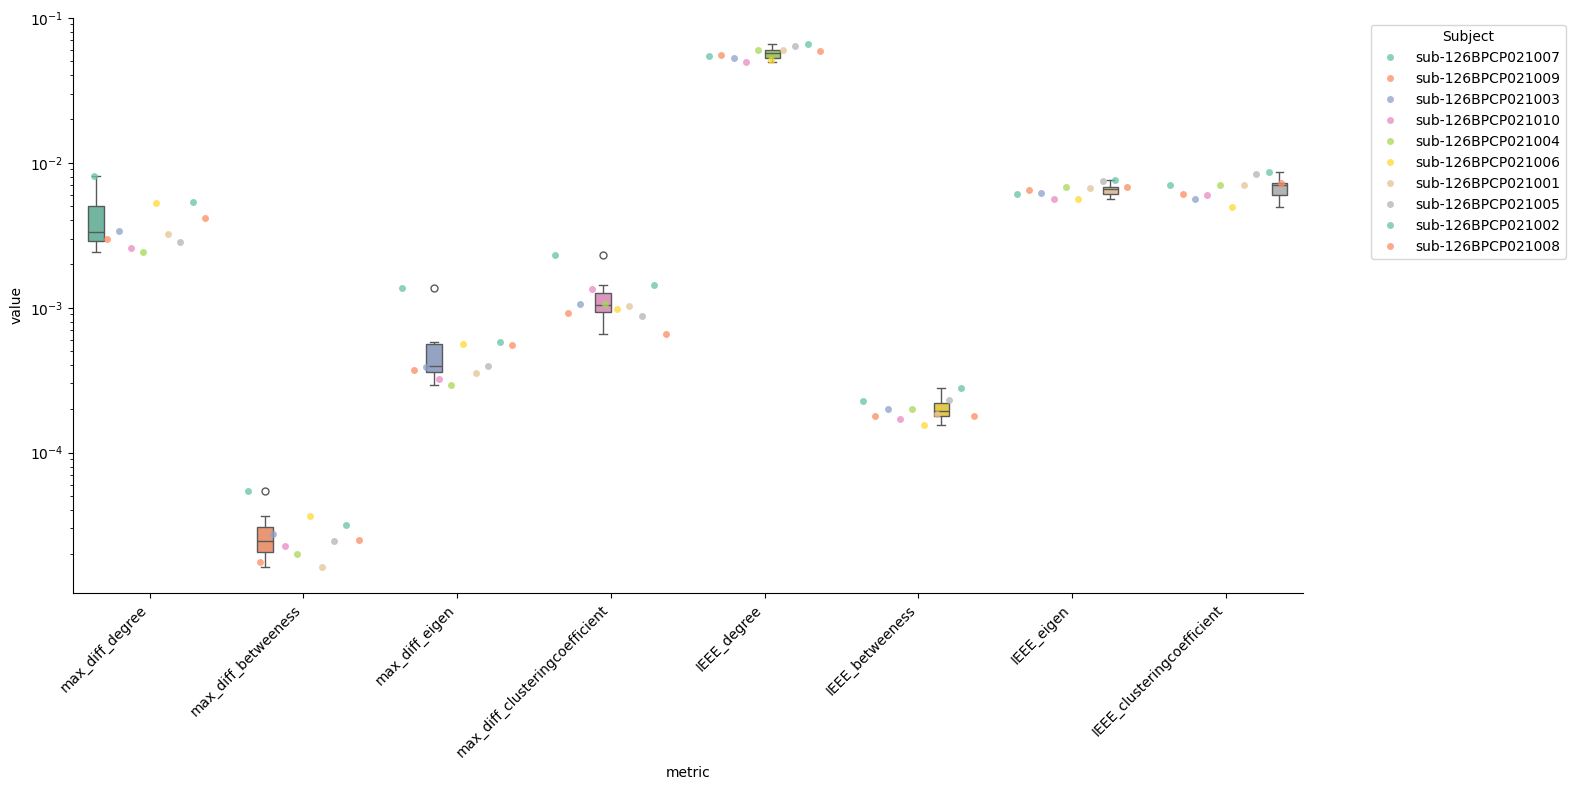

In [28]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt


# Melt the DataFrame to long-form for seaborn
statics_melted = statics.melt(id_vars=['subject'], var_name='metric', value_name='value')

# Create the boxplot and swarmplot using seaborn.catplot
g = sns.catplot(
    data=statics_melted, kind="box", x='metric', y='value',
    palette="Set2", height=8, aspect=2, dodge=True  # Adjust the height and aspect ratio
)

# Overlay the swarmplot on the boxplot
sns.swarmplot(
    data=statics_melted, x='metric', y='value',  hue='subject',
    palette="Set2", dodge=True, alpha=0.75, ax=g.ax
)

# Rotate x-axis labels
plt.xticks(rotation=45, ha='right')

# Adjust the legend position
g.ax.legend(title='Subject', bbox_to_anchor=(1.05, 1), loc='upper left')
g.set(yscale="log")

# Use tight_layout to prevent overlapping
plt.tight_layout()

# Show the plot
plt.show()


In [29]:
fslstats_hmc_values=pd.read_csv('/home/mina94/scratch/fixSeed_threads/eval_SSD_hmc/fslstats_hmc_values.csv')
fslstats_N4bias_values=pd.read_csv('/home/mina94/scratch/fixSeed_threads/eval_SSD_N4bias/fslstats_N4bias_values.csv')
fslstats=pd.DataFrame()
fslstats['hmc']=fslstats_hmc_values['Sum_of_squared_differences']
fslstats['N4bias']=fslstats_N4bias_values['Sum_of_squared_differences']


/tmp/ipykernel_1524691/2937359625.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(
/tmp/ipykernel_1524691/2937359625.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.swarmplot(
/home/mina94/scratch/fixSeed_threads/myenv2/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 81.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/mina94/scratch/fixSeed_threads/myenv2/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 70.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
No artis

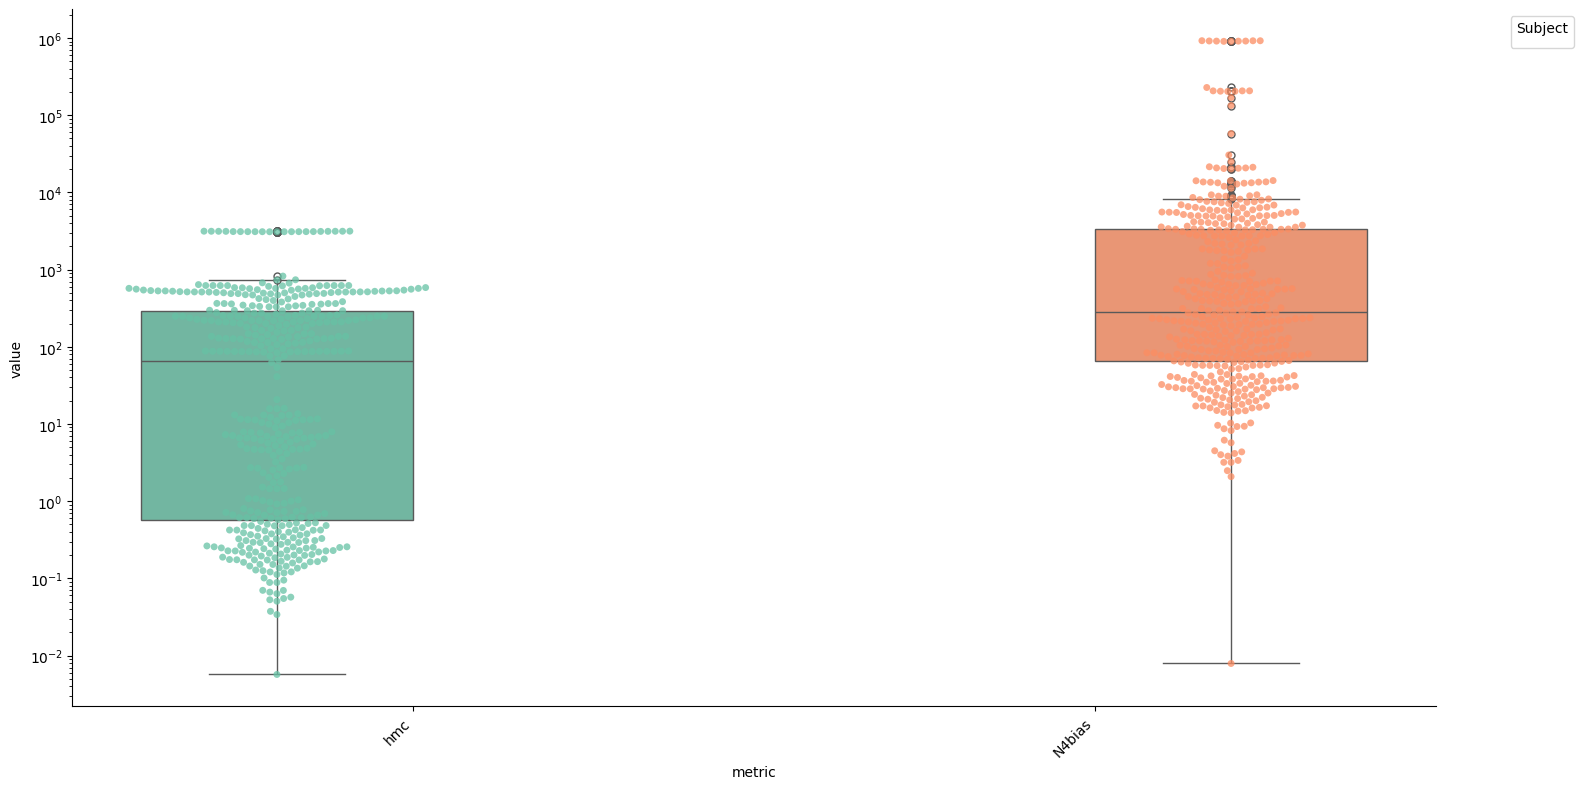

In [30]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load your CSV data
fslstats_hmc_values = pd.read_csv('/home/mina94/scratch/fixSeed_threads/eval_SSD_hmc/fslstats_hmc_values.csv')
fslstats_N4bias_values = pd.read_csv('/home/mina94/scratch/fixSeed_threads/eval_SSD_N4bias/fslstats_N4bias_values.csv')

# Create a new DataFrame combining the relevant columns
fslstats = pd.DataFrame()
fslstats['hmc'] = fslstats_hmc_values['Sum_of_squared_differences']
fslstats['N4bias'] = fslstats_N4bias_values['Sum_of_squared_differences']

# Melt the DataFrame to long-form for seaborn plotting
fslstats_melted = fslstats.melt(var_name='metric', value_name='value')

# Create the boxplot and swarmplot using seaborn.catplot
g = sns.catplot(
    data=fslstats_melted, kind="box", x='metric', y='value',
    palette="Set2", height=8, aspect=2, dodge=True  # Adjust the height and aspect ratio
)

# Overlay the swarmplot on the boxplot
sns.swarmplot(
    data=fslstats_melted, x='metric', y='value',
    palette="Set2", dodge=True, alpha=0.75, ax=g.ax
)

# Rotate x-axis labels for better visibility
plt.xticks(rotation=45, ha='right')

# Adjust the legend position
g.ax.legend(title='Subject', bbox_to_anchor=(1.05, 1), loc='upper left')
g.set(yscale="log")

# Use tight_layout to prevent overlapping
plt.tight_layout()

# Show the plot
plt.show()


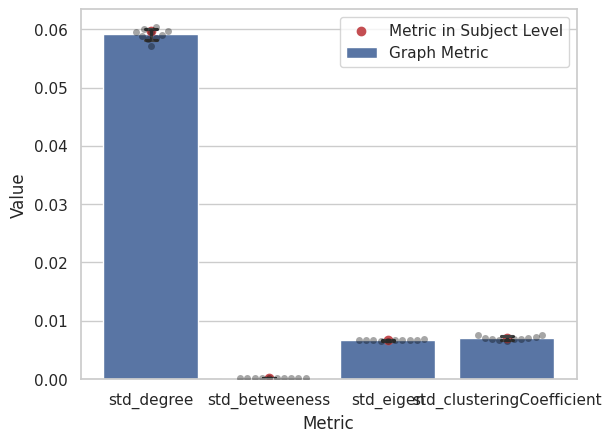

In [ ]:
import seaborn as sns
sns.set(style="whitegrid")
np.random.seed(0)
# Convert IEEE_metric to DataFrame
IEEE_df = pd.DataFrame.from_dict(IEEE_metric['sub-126BPCP021001']['std_metric'], orient='index', columns=['Value']).reset_index()
IEEE_df = IEEE_df.rename(columns={'index': 'Metric'})

# Convert subdict_ses1 to DataFrame and melt
MCA_df = pd.DataFrame(subdict_ses1['sub-126BPCP021001']['std_metric'])
MCA_long_df = pd.melt(MCA_df, var_name='Metric', value_name='Value')

# Create the bar plot with standard deviation caps
sns.barplot(x="Metric", y="Value", data=MCA_long_df, capsize=.1, errorbar="sd", label="Graph Metric")

# Overlay the swarm plot with individual data points
sns.swarmplot(x="Metric", y="Value", data=MCA_long_df, color="0", alpha=.35)

# Plot the IEEE metric data
plt.scatter(IEEE_df['Metric'], IEEE_df['Value'], marker='o', color='r', label='Metric in Subject Level')

# Add labels and legend
plt.xlabel('Metric')
plt.ylabel('Value')
plt.legend()

In [29]:
subdict_ses1[]

TypeError: unhashable type: 'slice'

In [33]:
df_IEEE_metric=pd.DataFrame.from_dict(IEEE_metric['sub-126BPCP021007']['std_metric'])
df_IEEE_metric

ValueError: If using all scalar values, you must pass an index

In [ ]:
import dash
from dash import dcc, html
from dash.dependencies import Input, Output
import plotly.graph_objects as go
import plotly.subplots as sp
import numpy as np
from scipy.stats import norm

# Example data structure similar to df_sd_dic
np.random.seed(42)  # For reproducibility

# Initialize Dash app
app = dash.Dash(__name__)

# Layout of the app
app.layout = html.Div([
    html.H1("Histograms of Keys for iteration of one subject"),
    dcc.Dropdown(
        id='subject-dropdown',
        options=[{'label': metrics, 'value': metrics} for subject in iter_dict['graph_metrics'].keys()],
        multi=True,  # Allow multiple selection
        value=list(iter_dict['graph_metrics'].keys()),  # Default value: All subjects selected
        style={'width': '50%'}
    ),
    dcc.Graph(id='histogram-plot')
])

# Callback to update the plot based on selected subjects
@app.callback(
    Output('histogram-plot', 'figure'),
    [Input('subject-dropdown', 'value')]
)
def update_plot(selected_subjects):
    # Create subplots with shared x-axis
    fig = sp.make_subplots(rows=2, cols=3, subplot_titles=['degree_centralities', 'betweenness_centralities', 'eigenvector_centralities', 'clustering_coefficients', 'shortest_path_lengths', 'small_worldness'], shared_yaxes=True, shared_xaxes='rows',
                           row_heights=[0.4, 0.4])

    # Loop through the selected subjects and add histograms
    for i, key in enumerate(['degree_centralities', 'betweenness_centralities', 'eigenvector_centralities', 'clustering_coefficients', 'shortest_path_lengths', 'small_worldness'], start=1):
        for subject in selected_subjects:
            # Add histogram for each selected subject
            fig.add_trace(go.Histogram(x=iter_dict['graph_metrics'][subject][key], name=f'{subject} - {key}'), row=(i-1)//3 + 1, col=(i-1)%3 + 1, )
            # x_curve = np.linspace(min(df_sd_dic[subject][key]), max(df_sd_dic[subject][key]), 100)
            # y_curve = norm.pdf(x_curve, loc=np.mean(df_sd_dic[subject][key]), scale=np.std(df_sd_dic[subject][key]))
            # fig.add_trace(go.Scatter(x=x_curve, y=y_curve, mode='lines', name=f'Normal Curve - {subject} - {key}'), row=(i-1)//3 + 1, col=(i-1)%3 + 1)

    # Update layout for better readability
    fig.update_layout(
        title_text=f'Histograms of graph metrics for Subjects',
        # xaxis_title='standard deviation',
        height=800,  # Adjust the height of the entire figure
    )
    fig.update_xaxes(tickformat='e', exponentformat='e', showticksuffix='none', ticksuffix='e+0')


    return fig

# Run the app
if __name__ == '__main__':
    app.run_server(debug=True, port=8051)



